# Distribution from Moments

We will use the orthogonal Legendre-Polynoms as moment generating function in order to simplify the distribution recovery from moments.

## Generate Data

In [1]:
from scipy.stats import norm
import pandas as pd
import numpy as np
from numpy.polynomial.legendre import Legendre as le
from plotnine import *
nCPU = 30

In [2]:
from cflDensity import *

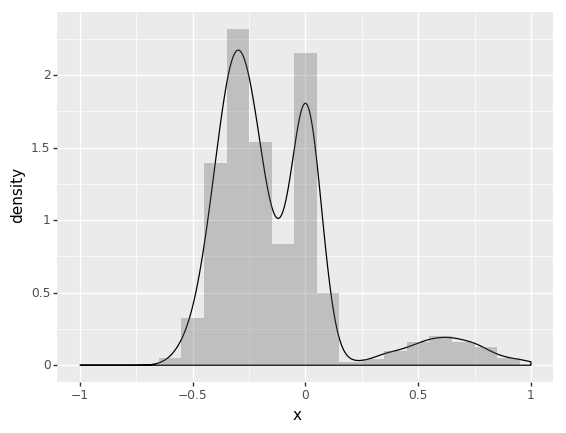

In [3]:
stats = pd.DataFrame({"mean": [-.3, 0, .6],
                      "sd": [.1, .05, .2],
                      "size": [2000, 1000, 300]})
rands = list()
for i,stat in stats.iterrows():
    rands.extend(norm.rvs(stat["mean"], stat["sd"], stat["size"].astype(int), random_state=1))

mData = pd.DataFrame({'x': rands})
ind = (-1 <= mData['x']) & (mData['x'] <= 1)
mData = mData[ind]
pl = (ggplot(aes(x='x'), data=mData) + geom_density() +
    geom_histogram(aes(x='x',y='..density..'), position='identity',
                   alpha=.3, binwidth=.1) + xlim(-1, 1))
_ = pl.draw()

## Reconstructing Density Functions

Reults of differnent approaches are refferd to by a 'dict' so they can be replaced indevidually.

In [4]:
plotSets =  {}
xses = np.linspace(-1, 1, 1000) # plotting support
volume = max(xses) - min(xses)

### The True Generating Density

In [5]:
def trueDens(x, stats = stats):
    result = 0
    for i,stat in stats.iterrows():
        result += norm.pdf(x, stat["mean"], stat["sd"]) * stat["size"]
    result = result / sum(stats["size"])
    return(result)

plotSets['true'] = pd.DataFrame({'x':xses,
                                 'y':trueDens(xses),
                                 'type':'true'})

### Using Legendre Polynomial Basis

In [6]:

for nbase in (3, 10, 50):
    this = ('legendre ' + str(nbase))
    coeff = tuple()
    c = (1,)
    n = 1
    for i in range(nbase):
        coeff += ( ((2*n+1) / 2) * sum(le(c)(mData["x"]))/len(mData),)
        c = (0,) + c
        n += 1
    fvals = le(coeff)(xses)
    normF = volume * sum(fvals)/len(xses)
    plotSets[this] = pd.DataFrame({'x':xses,
                                   'y':fvals / normF,
                                   'type':this})

### Using the Characteristic Function (CF)

The CF $\varphi\colon \mathbb R^n \to \mathbb R^n$ of the desity $f\colon \Omega \to \mathbb R^+$ is
$$\varphi(t) = \mathbb E (e^{itx}) = \int_\Omega e^{itx} f(x) \mathrm{dx}
\approx \frac{1}{|X|}\sum_{x\in X} e^{itx} = \hat \varphi(t)$$
for some finite sample $X$ drawn from $f$. This fourier transformation of $f$ and can be inverted:
$$
f(x) = \frac{1}{(2\pi)^n} \int_{\mathbb R ^n} \varphi(t)e^{-itx} \mathrm{dt}
\approx \frac{V(T)}{|T|(2\pi)^n} \sum_{t \in T} \hat \varphi(t)e^{-itx} = \hat f(x)
$$
for some finite grid $T=(t_1, ..., t_m)$ and a normalizing constant $\lambda$. The CF is Hermitian: $\varphi(t) = \overline{\varphi(-t)}$.

In [7]:
def phi(x, ts):
    return [(sum(np.exp(1j*y*x)) / len(x)) for y in ts]
def fRev(xs, phits, ts):
    vt = max(ts) - min(ts)
    return [sum(phits * np.exp(-1j*ts*x)) * vt / (len(ts)*2*np.pi) for x in xs]
def getftd(xses, x, ts):
    phits = phi(x, ts)
    fvals = np.real(fRev(xses, phits, ts))
    return fvals

In [8]:
for bound in (10, 50, 100):
    ys = np.arange(-bound, bound+1)
    this = ('fourier ' + str(bound))
    vals = getftd(xses, mData['x'], ys)
    plotSets[this] = pd.DataFrame({'x':xses,
                                  'y':vals,
                                  'type':this})

The time and memry needed is in $\mathcal O(|X| + |T|^d + |Y|)$ where $Y$ is the set of points at which $\hat f$ is evaluated. This becomes infeasible for high dimensions $d$ especially with high grid resolutions $|T|$.

#### Direct using the Bessel function of the first kind

Calclating $f$ directly from the samples without the intermediate $\varphi$.

$$\hat f(x) := \frac{V(T)}{|T|(2\pi)^n} \sum_{t \in T} \hat \varphi(t)e^{-itx}
= \frac{V(T)}{|X||T|(2\pi)^n} \sum_{x'\in X} \sum_{t \in T} e^{it(x'-x)}$$

Even better: Using the exact integral over $\varphi$ over the n-ball
$\mathbb B^n(r) = \left\{x \in \mathbb R^n |\,||x||_2 \le r \right\}$.

$$
\tilde f(x|r) := \frac{1}{(2\pi)^n} \int_{\mathbb B^n(r)} \hat \varphi(t)e^{-itx} \mathrm{dt}
= \frac{1}{|X|(2\pi)^n} \sum_{x'\in X} \int_{\mathbb B^n(r)} e^{it(x'-x)} \mathrm{dt}\\
= \frac{1}{|X|(2\pi)^n} \sum_{x'\in X} \left(\frac{2 \pi r}{||x'-x||_2}\right)^{n/2} J_{n/2}(r||x'-x||_2)
= \frac{r^{n/2}}{|X|(2\pi)^{n/2}} \sum_{x'\in X} \frac{J_{n/2}(r||x'-x||_2)}{||x'-x||_2^{n/2}}
$$

For $x = x'$ the term $\frac{J_{n/2}(r||x'-x||_2)}{||x'-x||_2^{n/2}}$ is not defined.
But since $\int_{\mathbb B^n(r)} e^{it \cdot 0} \mathrm{dt} = \pi^{n/2} r^n / \Gamma(n/2 + 1)$
is the volume of the $n$-ball these terms can be replaced:

$$
\tilde f(x|r) = \frac{r^{n/2}}{|X|(2\pi)^{n/2}} \sum_{x'\in X} \beta(x, x'|r) \\
\beta(x, x'|r) = \left\{\begin{array}{lr}
        \frac{r^{n/2}}{\Gamma\left(\frac{n}{2} + 1\right) 2^{n/2}}, & \text{for } x = x'\\
        \frac{J_{n/2}(r||x'-x||_2)}{||x'-x||_2^{n/2}}, & \text{for } x \ne x'
        \end{array}\right.
$$

Integral solution found here: https://math.stackexchange.com/questions/2103531/integral-of-complex-exponential-inside-a-ball

In [9]:
sdata = mData['x'].values.reshape(-1, 1)
sxses = xses.reshape(-1, 1)
for bound in (10, 50, 100):
    this = ('fourier direct ' + str(bound))
    vals = getftd2(sxses, sdata, bound)
    plotSets[this] = pd.DataFrame({'x':xses,
                                  'y':vals,
                                  'type':this})

The time and memry needed is in $\mathcal O(|X| \cdot |Y| \cdot n)$ where $Y$ is the set of points at which $\tilde f$ is evaluated.

The summands of $\tilde f$ are expressed in terms of the Bassel function for $x \ne x'$ and else the volume of $\mathbb B^n$. We check for numeric difficulties as $x$ approches $x'$.

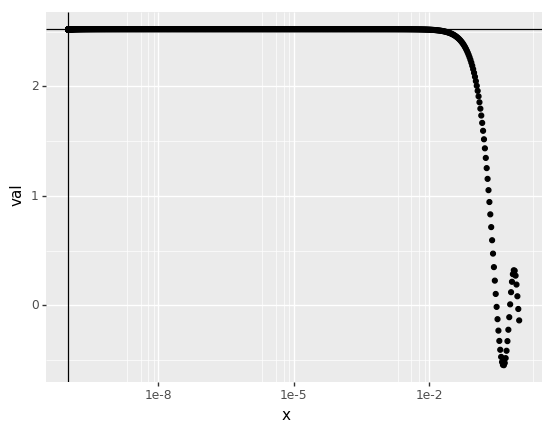

<ggplot: (8752137089954)>

In [10]:
r = 10
x2 = 1e-10
sec = x2 + np.logspace(np.log10(1e-20), 0, num = int(1e3))
vals = [np.real(np.asscalar(beta(r, x1, x2))) for x1 in sec]
pltDat = pd.DataFrame({'x1':sec,
                      'val':vals})
lvl = np.real(np.asscalar(beta(r, x2, x2)))
(ggplot(aes('x1', 'val'), pltDat) + geom_point() + scale_x_log10() +
 geom_hline(yintercept = lvl) + geom_vline(xintercept = x2) + xlab('x'))

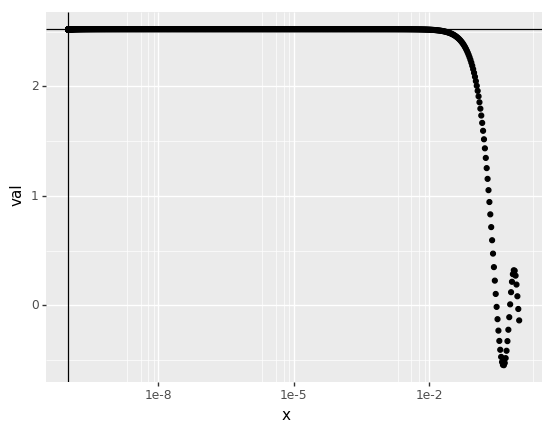

<ggplot: (8752106896581)>

In [39]:
r = 10
x2 = 1e-10
sec = x2 + np.logspace(np.log10(1e-20), 0, num = int(1e3))
vals = [np.real(np.asscalar(beta(r, x1, x2))) for x1 in sec]
pltDat = pd.DataFrame({'x1':sec,
                      'val':vals})
lvl = np.real(np.asscalar(beta(r, x2, x2)))
(ggplot(aes('x1', 'val'), pltDat) + geom_point() + scale_x_log10() +
 geom_hline(yintercept = lvl) + geom_vline(xintercept = x2) + xlab('x'))

The vertical line in the above plot is the value of $x'$ and the horizontal line the correct value of $\beta(x',x')$. The dots are evaluations of $\beta(x, x')$. The result seems nummerically stable even for $x$ very close to $x'$.

#### Plotting the CF

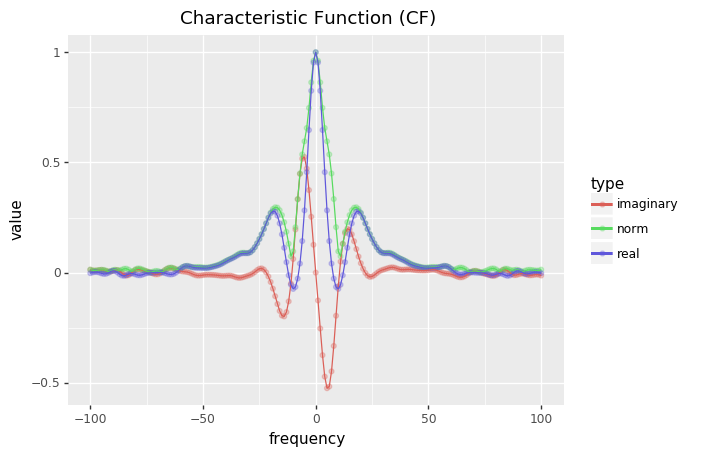

<ggplot: (8752002897430)>

In [11]:
ts = np.arange(-100, 101)
ff = phi(mData['x'], ts)
df = pd.concat([pd.DataFrame({'ys':ys, 'ff':np.real(ff), 'type':'real'}),
               pd.DataFrame({'ys':ys, 'ff':np.imag(ff), 'type':'imaginary'}),
               pd.DataFrame({'ys':ys, 'ff':np.absolute(ff), 'type':'norm'})])
(ggplot(aes('ys', 'ff', color='type'), df) + geom_point(alpha=.3) +
geom_line() + ggtitle('Characteristic Function (CF)') + xlab('frequency') + ylab('value'))

### Plotting

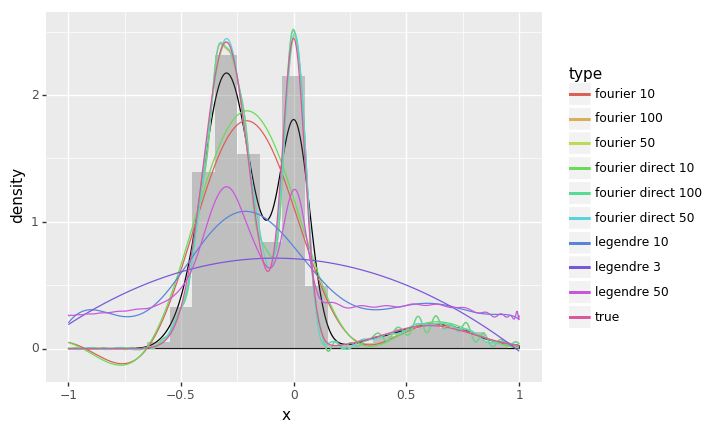

<ggplot: (8752002913961)>

In [12]:
allData = pd.concat(plotSets)
pl + geom_line(aes('x', 'y', color='type'), data=allData)

### Error Squares

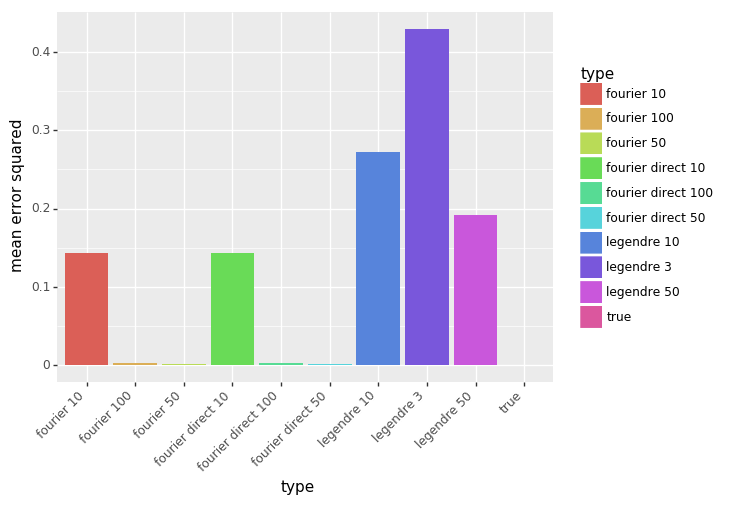

<ggplot: (-9223363284853576367)>

In [13]:
trueDens = plotSets['true']['y']
coll = {}
for this, df in plotSets.items():
    diff = df['y'] - trueDens
    err = np.dot(diff, diff) / len(diff)
    coll[this] = pd.DataFrame({'mean error squared':[err],
                              'type':[this]})
errData = pd.concat(coll)
    
(ggplot(aes('type', 'mean error squared', fill='type'), errData) +
   geom_bar(stat="identity") +
   theme(axis_text_x = element_text(rotation = 45, hjust = 1)))

### Over Frequencies of CF

In [14]:
from multiprocessing import Pool
def err(dat):
    bound = dat[0]
    xses = dat[1]
    x = dat[2]
    ys = np.arange(-bound, bound+1)
    values = getftd(xses, x, ys)
    diff = (values - trueDens) / len(trueDens)
    return np.dot(diff, diff)
def err_direct(dat):
    bound = dat[0]
    xses = dat[1].reshape(-1, 1)
    x = dat[2].values.reshape(-1, 1)
    values = getftd2(xses, x, bound)
    diff = (values - trueDens) / len(trueDens)
    return np.dot(diff, diff)

In [15]:
bounds = np.logspace(0, 2.5, num = 100).astype(int)
p = Pool(nCPU)
doData = [(bound, xses, mData['x']) for bound in bounds]
vals = p.map(err, doData)
errData = pd.DataFrame({'error-sq':vals,
                        'type':'indirect',
                       'max-freq':list(bounds)})
vals = p.map(err_direct, doData)
errData = errData.append(pd.DataFrame({'error-sq':vals,
                                       'type':'direct',
                                       'max-freq':list(bounds)}))

A common meassure error ist the $L_2$ loss function
$$
L(r) = \int_\Omega \left(\tilde f(x|r) - f(x)\right)^2 \mathrm{dx}
$$
which is estimated here:

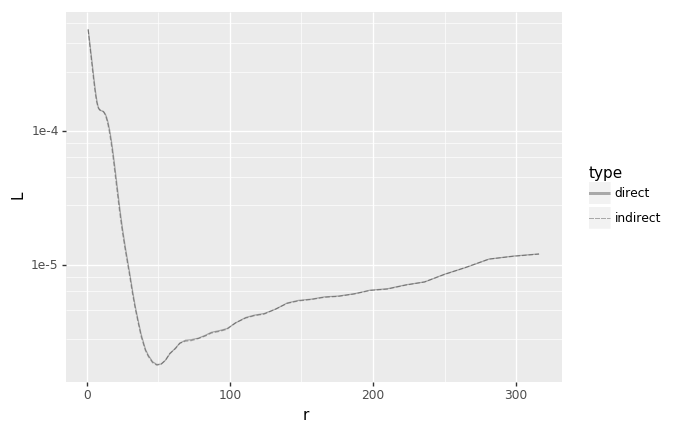

<ggplot: (8752001110483)>

In [16]:
(ggplot(aes('max-freq', 'error-sq', linetype = 'type'), errData) + geom_line(alpha=.3) +
   ylab('L') + xlab('r') + scale_y_log10())

Another measure is the Kullback-Leibler-Divergenz (KLD):
$$
\text{KLD}(r) = \int_\Omega f(x) \log \frac{f(x)}{\tilde f(x|r)} \mathrm{dx}.
$$

In [17]:
def kld_old(dat):
    bound = dat[0]
    xses = dat[1]
    x = dat[2]
    ys = np.arange(-bound, bound+1)
    values = getftd(xses, x, ys)
    dist = np.sum(trueDens * np.log(trueDens/values + 0j))
    return np.real(dist)
def kld(dat):
    bound = dat[0]
    xses = dat[1].reshape(-1, 1)
    x = dat[2].values.reshape(-1, 1)
    values = getftd2(xses, x, bound, log=True)
    dist = np.sum(trueDens * (np.log(trueDens) - values))
    return np.real(dist)

In [18]:
bounds = np.logspace(0, 2.5, num = 100).astype(int)
p = Pool(nCPU)
doData = [(bound, xses, mData['x']) for bound in bounds]
vals = p.map_async(kld_old, doData)
dist = vals.get()
errData = pd.DataFrame({'dist':dist,
                        'log-dist':np.log(dist),
                        'type':'indirect',
                        'max-freq':list(bounds)})
vals = p.map_async(kld, doData)
dist = vals.get()
p.close()
errData = errData.append(pd.DataFrame({'dist':dist,
                                       'log-dist':np.log(dist),
                                       'type':'direct',
                                       'max-freq':list(bounds)}))

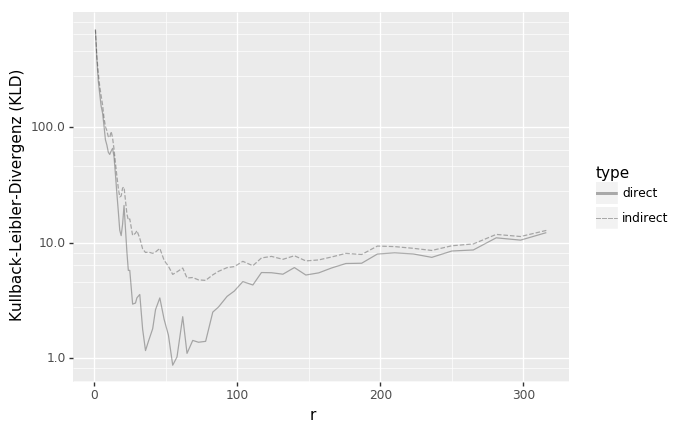

<ggplot: (8752107146311)>

In [19]:
(ggplot(aes('max-freq', 'dist', linetype = 'type'), errData) + geom_line(alpha=.3) +
   ylab('Kullback-Leibler-Divergenz (KLD)') + xlab('r') + scale_y_log10())

### For Different Sample Sizes (incremental)

In [20]:
numberOfSampleSizes = 100
bounds = np.logspace(0, 2, num = 100).astype(int)
colls = []
p = Pool()
sampleSizes = set(np.logspace(1, np.log10(len(mData)), num = numberOfSampleSizes).astype(int))
selData = mData.sample(frac = 1, random_state = 1)
for nSamp in sampleSizes:
    xData = selData.head(nSamp)
    doData = [(bound, xses, xData['x']) for bound in bounds]
    vals = p.map_async(err_direct, doData)
    colls.append(pd.DataFrame({'error-sq':vals.get(),
                              'max-freq':list(bounds),
                              'nSamples_group':str(nSamp),
                              'nSamples':nSamp}))
p.close()

errmData = pd.concat(colls)

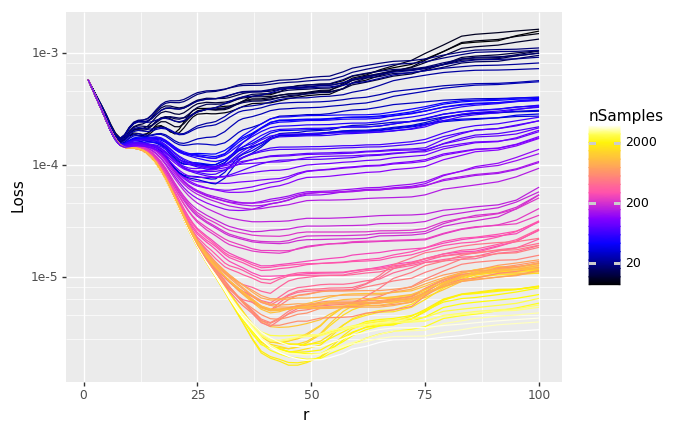

<ggplot: (-9223363284749754929)>

In [21]:
(ggplot(aes('max-freq', 'error-sq', color = 'nSamples', group = 'nSamples_group'),
           errmData) + geom_line() +
    ylab('Loss') + xlab('r') + scale_y_log10() +
    scale_color_continuous(name = 'gnuplot2',
                           trans = 'log',
                           breaks = (20, 200, 2000),
                           labels = (20, 200, 2000)))

In [22]:
numberOfSampleSizes = 100
bounds = np.logspace(0, 2, num = 100).astype(int)
kcolls = []
p = Pool()
sampleSizes = set(np.logspace(1, np.log10(len(mData)), num = numberOfSampleSizes).astype(int))
selData = mData.sample(frac = 1, random_state = 1)
for nSamp in sampleSizes:
    xData = selData.head(nSamp)
    doData = [(bound, xses, xData['x']) for bound in bounds]
    vals = p.map_async(kld, doData)
    kcolls.append(pd.DataFrame({'error-sq':vals.get(),
                              'max-freq':list(bounds),
                              'nSamples_group':str(nSamp),
                              'nSamples':nSamp}))
p.close()

kldData = pd.concat(kcolls)

/homes/olymp/dominik.otto/local/lib/python3.6/site-packages/plotnine/scales/scale.py:521: RuntimeWarning: invalid value encountered in log10
  return self.trans.transform(x)


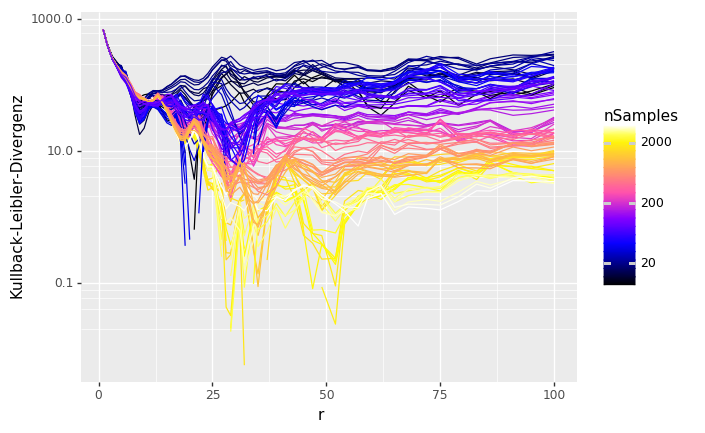

<ggplot: (8752106681243)>

In [38]:
(ggplot(aes('max-freq', 'error-sq', color = 'nSamples', group = 'nSamples_group'),
           kldData) + geom_line() +
    ylab('Kullback-Leibler-Divergenz') + xlab('r') + scale_y_log10() +
    scale_color_continuous(name = 'gnuplot2',
                           trans = 'log',
                           breaks = (20, 200, 2000),
                           labels = (20, 200, 2000)))

### Best Frequencies

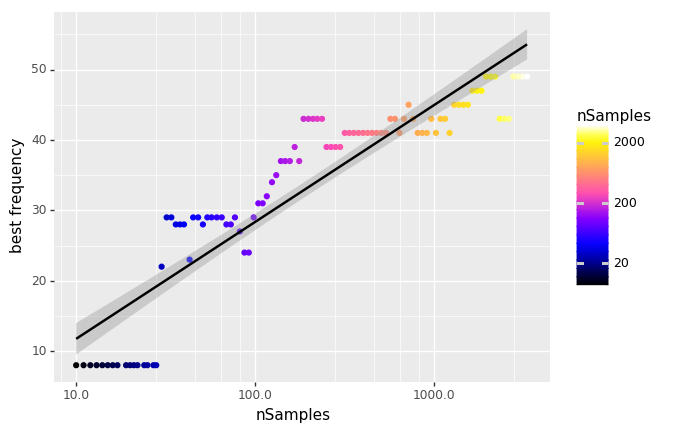

<ggplot: (8752001161059)>

In [24]:
pcolls = []
for df in colls:
    ind = df['error-sq'].idxmin()
    pcolls.append(df.loc[[ind]])
bestFreqDat = pd.concat(pcolls)

(ggplot(aes('nSamples', 'max-freq', color = 'nSamples'),
           bestFreqDat) + geom_point() +
    ylab('best frequency') +
    scale_x_log10() + geom_smooth(method = 'lm') +
    scale_color_continuous(name = 'gnuplot2',
                           trans = 'log',
                           breaks = (20, 200, 2000),
                           labels = (20, 200, 2000)))

### Finding Obtimal Frequency by Cross Validation

Let $r_{cross}$ be the parameter that maximizes the objective function
$$
\mathcal L (r) = \int_\Omega \tilde f_{test}(x|r) \cdot f(x) \mathrm{dr}
\approx \frac{1}{|X|} \sum_{x_k \in X} \tilde f_{test}(x_k|r)
$$
where
$$
\tilde f_\text{test}(x_k|r) = \tilde f_{(-k)}(x_k|r) - \eta(r)\\
\tilde f_{(-k)}(x|r) = \frac{r^{n/2}}{|X|(2\pi)^{n/2}} \sum_{x'\in X \setminus \{x_k\} } \beta(x, x'|r)\\
\eta(r) = - \frac{r^{n/2}}{|X|(2\pi)^{n/2}} \beta(0, 0|r)
$$
is the cross validation version of $\tilde f$ excluding $x_k$ from its traing set and subtracting the regularizing term $\eta$ to increase the cost of high frquencies $r$. Evaluating $\mathcal L$ has a cost of $\mathcal O(|X|^2)$.

Note that $\tilde f_{(-k)}(x|r) = \tilde f(x|r) - \eta(r)$ since for all $x: \beta(x,x|r) = \beta(0,0|r)$ hence
$$
\mathcal L (r) \approx \frac{1}{|X|} \sum_{x_k \in X} \tilde f(x_k|r) - \frac{2\eta(r)}{|X|}.
$$

#### The Cross Validation Estimator of Risk

Risk is the expected value of the $L_2$ loss function:
$$
R(r) = \mathbb E \left[ L(r) \right]
$$
and the cross validation estimate is given by

$$
R(r) \approx \int_\Omega \left( \tilde f (x|r) \right)^2 \mathrm{dx} - \frac{2}{|X|} \sum_{x_k \in X} \tilde f_{(-k)}(x_k|r)\\
\tilde f (x|r) = \frac{r^{n/2}}{|X|(2\pi)^{n/2}} \sum_{x'\in X} \frac{J_{n/2}(r||x'-x||_2)}{||x'-x||_2^{n/2}} \\
\left( \tilde f (x|r) \right)^2 = \frac{r^n}{|X|(2\pi)^n} \sum_{x',x''\in X} \frac{J_{n/2}(r||x'-x||_2)J_{n/2}(r||x''-x||_2)}{||x'-x||_2^{n/2} ||x''-x||_2^{n/2}}
$$
There is a connection to the objective function $\mathcal L$ since $\tilde f$ is also a generating density of the sample $X$:
$$
\int_\Omega \tilde f (x|r) \tilde f (x|r) \mathrm{dx} \approx \frac{1}{|X|} \sum_{x \in X} \tilde f(x|r) = \frac{1}{|X|} \sum_{x \in X} \left[ \tilde f_{(-k)}(x|r) + \eta(r) \right]\\
\Rightarrow R(r) \approx \frac{1}{|X|} \eta(r) - \frac{1}{|X|} \sum_{x_k \in X} \tilde f_{(-k)}(x_k|r) = - \mathcal L(r)
$$

#### Plotting $\tilde f_{test}$ for 100 Samples

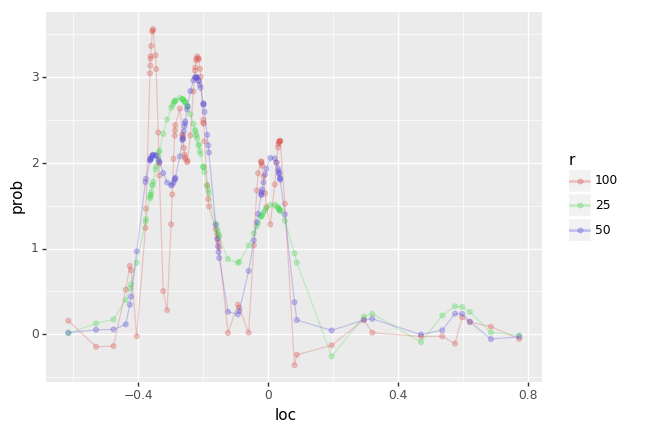

<ggplot: (-9223363284853625670)>

In [25]:
testData = selData.head(100).values.reshape(-1, 1)
freqs = (25, 50, 100)
sets = []
for freq in freqs:
    dens = crossDens(freq, testData)
    sets.append(pd.DataFrame({'prob':dens,
                              'r':str(freq),
                              'loc':testData.flatten()}))
testDat = pd.concat(sets)
(ggplot(aes('loc', 'prob', color='r'), testDat) + geom_point(alpha=.3) + geom_line(alpha=.3))

#### Likelyhood of Radius for 100 Samples

In [26]:
import importlib
import cflDensity
importlib.reload(cflDensity)
from cflDensity import *
radii = np.arange(1, 200)
testData = selData.head(100).values.reshape(-1, 1)
def mll(r): return np.real(ll(r, x = testData, log=True))
p.close()
p = Pool(nCPU)
vals = p.map(mll, radii)
result = pd.DataFrame({'radius':radii,
                       'likelyhood':vals})
p.close()

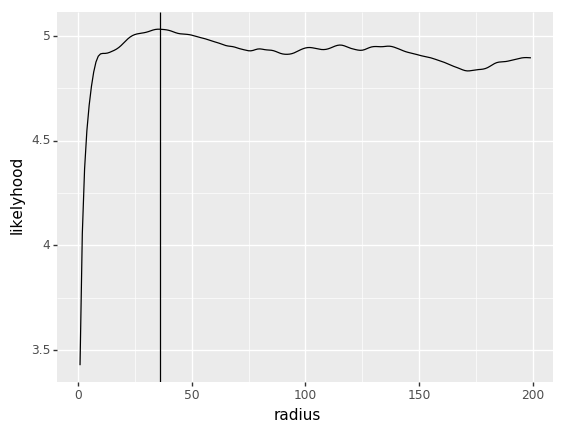

<ggplot: (8752107043248)>

In [27]:
maxIndex = result['likelyhood'].idxmax()
bestRad = result.loc[maxIndex, 'radius']
(ggplot(aes('radius', 'loss'), result) + geom_line() + geom_vline(xintercept = bestRad))

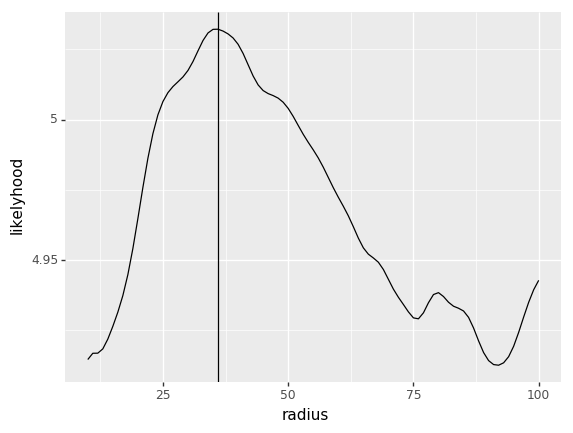

<ggplot: (8752105286741)>

In [28]:
cropresult = result.loc[(10 <= result['radius']) & (result['radius'] <= 100)]
(ggplot(aes('radius', 'likelyhood'), cropresult) + geom_line() + geom_vline(xintercept = bestRad))

The vertical line is the radius with the highes likelyhood by cross validation found.

#### Obtimizing $\tilde f_{test}$  without Lasso

In [29]:
p = Pool(nCPU)
samples = [selData.head(nSamp).values.reshape(-1, 1) for nSamp in sampleSizes]
radii = p.map_async(getBestRad, samples)
bestFreqDat['cross-val-freq'] = radii.get()
p.close()

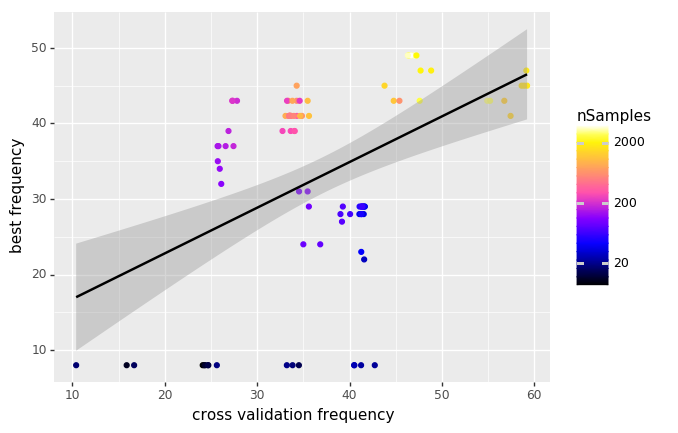

<ggplot: (8752105286888)>

In [30]:
(ggplot(aes('cross-val-freq', 'max-freq', color = 'nSamples'),
           bestFreqDat) + geom_point() +
    ylab('best frequency') + xlab('cross validation frequency') +
    geom_smooth(method = 'lm') +
    scale_color_continuous(name = 'gnuplot2',
                           trans = 'log',
                           breaks = (20, 200, 2000),
                           labels = (20, 200, 2000)))

In [31]:
p = Pool()
doData = [(r, xses, mData['x']) for r in bestFreqDat['cross-val-freq']]
crossErr = p.map_async(err_direct, doData)
bestFreqDat['cross-val-err'] = crossErr.get()
p.close()

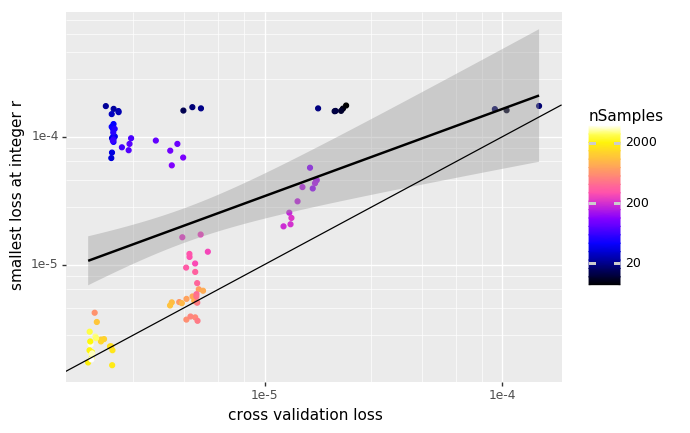

<ggplot: (-9223363284748091767)>

In [37]:
(ggplot(aes('cross-val-err', 'error-sq', color = 'nSamples'), bestFreqDat) + geom_point() +
 ylab('smallest loss at integer r') + xlab('cross validation loss') +
 geom_smooth(method = 'lm') +
 scale_x_log10() + scale_y_log10() +
 geom_abline(slope = 1) +
 scale_color_continuous(name = 'gnuplot2',
                        trans = 'log',
                        breaks = (20, 200, 2000),
                        labels = (20, 200, 2000)))

#### With Kullback–Leibler divergence

The Kullback–Leibler divergence $D_{KL}$ is defined as:
$$
D_{KL}(f, g) = \int_\Omega f(x) \log \frac{f(x)}{g(x)} \mathrm{dx}
\approx \frac{1}{|X|} \sum_{x \in X} \left [ \log f(x) - \log g(x) \right ].
$$

We want to find an $r$ such that $D_{KL}(f, \tilde f(r))$ is minimal. Hence an $r$ that maximizes
$$
\sum_{x \in X} \log \tilde f(x|r).
$$
This is equivalent to the maximum likelyhood approch.

### CF For Different Sample Sizes

In [33]:
freqs = np.arange(-100, 101)
def multiphi(data):
    vals = phi(data[1], data[2])
    result = pd.DataFrame({'real':np.real(vals),
                           'imaginary':np.imag(vals),
                           'absolute':np.absolute(vals),
                           'freq':np.arange(-100, 101),
                           'nSamples_group':str(data[0]),
                           'nSamples':data[0]})
    return result
p = Pool(nCPU)
doData = [(nSamp, selData.head(nSamp)['x'], freqs) for nSamp in sampleSizes]
vals = p.map(multiphi, doData)
freqData = pd.concat(vals)
p.close()

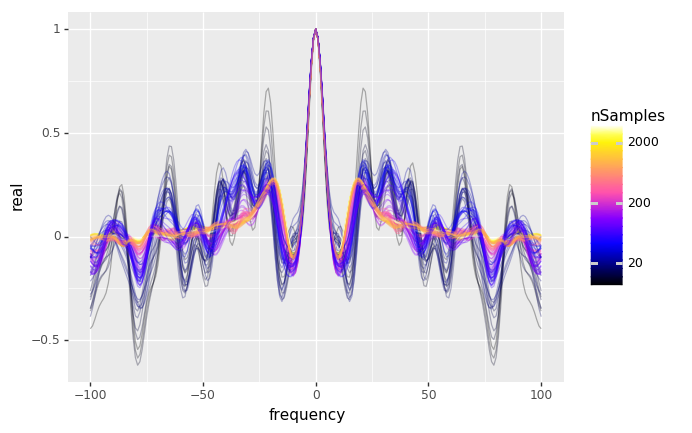

<ggplot: (-9223363284748920667)>

In [34]:
(ggplot(aes('freq', 'real', color = 'nSamples', group = 'nSamples_group'),
           freqData) + geom_line(alpha=.3) +
    xlab('frequency') +
    scale_color_continuous(name = 'gnuplot2',
                           trans = 'log',
                           breaks = (20, 200, 2000),
                           labels = (20, 200, 2000)))

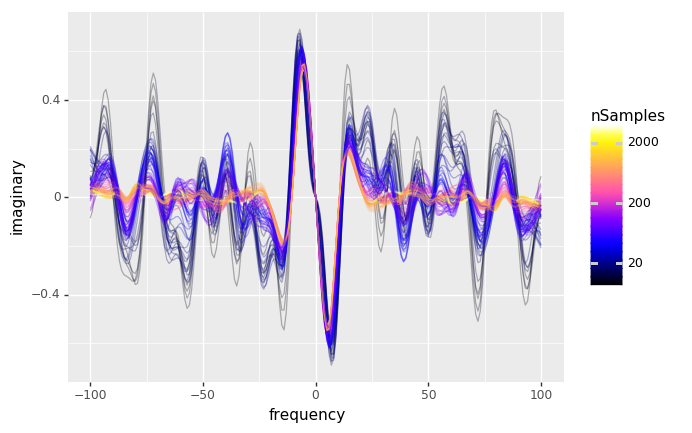

<ggplot: (8752105181402)>

In [35]:
(ggplot(aes('freq', 'imaginary', color = 'nSamples', group = 'nSamples_group'),
           freqData) + geom_line(alpha=.3) +
    xlab('frequency') +
    scale_color_continuous(name = 'gnuplot2',
                           trans = 'log',
                           breaks = (20, 200, 2000),
                           labels = (20, 200, 2000)))

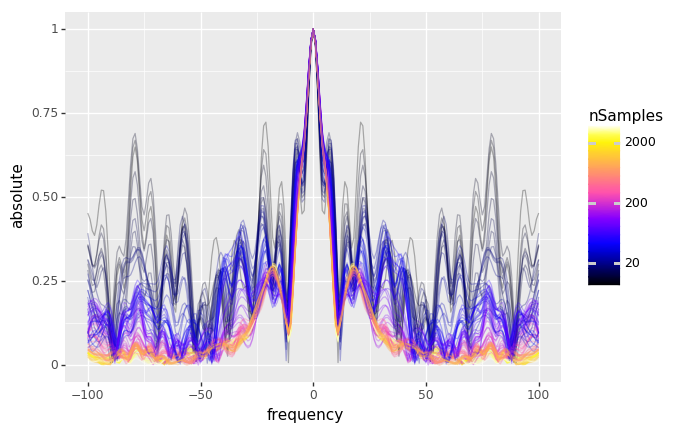

<ggplot: (8752001217572)>

In [36]:
(ggplot(aes('freq', 'absolute', color = 'nSamples', group = 'nSamples_group'),
           freqData) + geom_line(alpha=.3) +
    xlab('frequency') +
    scale_color_continuous(name = 'gnuplot2',
                           trans = 'log',
                           breaks = (20, 200, 2000),
                           labels = (20, 200, 2000)))